<a href="https://colab.research.google.com/github/anirbanmukherjee2709/tsai_end2.0_Session_7/blob/master/CMU_Q%26A_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator


import spacy
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#!pip install spacy --upgrade

In [ ]:
!wget http://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz

--2021-06-24 17:40:07--  http://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8254496 (7.9M) [application/x-gzip]
Saving to: ‘Question_Answer_Dataset_v1.2.tar.gz.4’

Question_Answer_Dat 100%[===================>]   7.87M  2.23MB/s    in 3.9s    

2021-06-24 17:40:11 (2.00 MB/s) - ‘Question_Answer_Dataset_v1.2.tar.gz.4’ saved [8254496/8254496]



In [ ]:
!tar -xvzf Question_Answer_Dataset_v1.2.tar.gz

Question_Answer_Dataset_v1.2/
Question_Answer_Dataset_v1.2/S08/
Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt
Question_Answer_Dataset_v1.2/S08/data/
Question_Answer_Dataset_v1.2/S08/data/set4/
Question_Answer_Dataset_v1.2/S08/data/set4/a6.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a5.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a4o.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a3.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a9.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a2.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a9.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a4.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a4.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a4.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a2.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a7o.htm
Question_Answer_Dataset_v1.2/S08/data/set4/a6.txt
Question_Answer_Da

In [ ]:
import pandas as pd
df_08 = pd.read_csv("/content/Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt", sep='\t', engine="python",error_bad_lines=False)
df_09 = pd.read_csv("/content/Question_Answer_Dataset_v1.2/S09/question_answer_pairs.txt", sep='\t', engine="python",error_bad_lines=False)
df_10 = pd.read_csv("/content/Question_Answer_Dataset_v1.2/S10/question_answer_pairs.txt", sep='\t', engine="python",error_bad_lines=False)
df = pd.concat([df_08,df_09,df_10])


df['Question'] = df['Question'].astype(str)
df['Answer'] = df['Answer'].astype(str)
df = df.dropna()
df.to_csv("cmu_qa_dataset.csv")

print("Number of records : ",len(df))
print(df[['Question','Answer']].head(n = 20))

Number of records :  2731
                                                             Question                                                                      Answer
0   Was Abraham Lincoln the sixteenth President of the United States?                                                                         yes
1   Was Abraham Lincoln the sixteenth President of the United States?                                                                        Yes.
2                  Did Lincoln sign the National Banking Act of 1863?                                                                         yes
3                  Did Lincoln sign the National Banking Act of 1863?                                                                        Yes.
4                                    Did his mother die of pneumonia?                                                                          no
5                                    Did his mother die of pneumonia?                             

Skipping line 765: '	' expected after '"'
Skipping line 876: '	' expected after '"'
Skipping line 1219: '	' expected after '"'


In [ ]:
%%bash
python -m spacy download en
#python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

In [ ]:
Question = Field(sequential=True,
                 #batch_first = True,
                 tokenize = tokenize_en, 
                 init_token = '<sos>', 
                 eos_token = '<eos>')


Answer = Field(sequential=True,
                 #batch_first = True,
                 tokenize = tokenize_en, 
                 init_token = '<sos>', 
                 eos_token = '<eos>')

fields = [('Question', Question),('Answer',Answer)]

In [ ]:
example = [data.Example.fromlist([df.Question.iloc[i],df.Answer.iloc[i]], fields) for i in range(df.shape[0])] 
train_data, test_data = data.Dataset(example, fields).split(split_ratio = 0.7)

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 1912
Number of testing examples: 819


In [ ]:
print(vars(train_data.examples[0]))

{'Question': ['is', 'antwerp', 'in', 'belgium', '?'], 'Answer': ['yes']}


In [ ]:
Question.build_vocab(train_data, min_freq = 2)
Answer.build_vocab(train_data, min_freq = 2)

print('Top 10 words in Question Vocab :', list(Question.vocab.freqs.most_common(10)))

import os, pickle
with open('CMU_Question_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Question.vocab.stoi, tokens)

  
with open('CMU_Answer_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Answer.vocab.stoi, tokens)

Top 10 words in Question Vocab : [('?', 1887), ('the', 999), ('of', 585), ('is', 565), ('what', 531), ('a', 371), ('in', 341), ('did', 284), ('was', 281), ('are', 253)]


In [ ]:
print(f"Unique tokens in source (Question) vocabulary: {len(Question.vocab)}")
print(f"Unique tokens in target (Answer) vocabulary: {len(Answer.vocab)}")

Unique tokens in source (Question) vocabulary: 1661
Unique tokens in target (Answer) vocabulary: 1181


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Curent Device is ", device)

Curent Device is  cuda


In [ ]:
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Question),
    sort_within_batch=True,
    device = device)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [ ]:
INPUT_DIM = len(Question.vocab)
OUTPUT_DIM = len(Answer.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1661, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1181, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1181, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,689,821 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0005)

In [ ]:
Answer_PAD_IDX = Answer.vocab.stoi[Answer.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = Answer_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        ques = batch.Question
        ans = batch.Answer
        
        optimizer.zero_grad()
        
        output = model(ques, ans)
        
        #ans = [ans len, batch size]
        #output = [ans len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        ans = ans[1:].view(-1)
        
        #ans = [(ans len - 1) * batch size]
        #output = [(ans len - 1) * batch size, output dim]
        
        loss = criterion(output, ans)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            ques = batch.Question
            ans = batch.Answer

            output = model(ques, ans, 0) #turn off teacher forcing

            #ans = [ans len, batch size]
            #output = [ans len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            ans = ans[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, ans)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 35
CLIP = 1

best_test_loss = float('inf')
test_losses = []
train_losses = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_iterator, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'cmu-qa-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

Epoch: 01 | Time: 0m 1s
	Train Loss: 5.940 | Train PPL: 379.996
	 Test. Loss: 4.034 |  Test. PPL:  56.491
Epoch: 02 | Time: 0m 1s
	Train Loss: 4.624 | Train PPL: 101.897
	 Test. Loss: 3.797 |  Test. PPL:  44.575
Epoch: 03 | Time: 0m 1s
	Train Loss: 4.514 | Train PPL:  91.253
	 Test. Loss: 3.794 |  Test. PPL:  44.428
Epoch: 04 | Time: 0m 1s
	Train Loss: 4.455 | Train PPL:  86.071
	 Test. Loss: 3.774 |  Test. PPL:  43.552
Epoch: 05 | Time: 0m 1s
	Train Loss: 4.423 | Train PPL:  83.336
	 Test. Loss: 3.734 |  Test. PPL:  41.861
Epoch: 06 | Time: 0m 1s
	Train Loss: 4.393 | Train PPL:  80.885
	 Test. Loss: 3.756 |  Test. PPL:  42.789
Epoch: 07 | Time: 0m 1s
	Train Loss: 4.356 | Train PPL:  77.981
	 Test. Loss: 3.798 |  Test. PPL:  44.594
Epoch: 08 | Time: 0m 1s
	Train Loss: 4.332 | Train PPL:  76.131
	 Test. Loss: 3.751 |  Test. PPL:  42.546
Epoch: 09 | Time: 0m 1s
	Train Loss: 4.287 | Train PPL:  72.739
	 Test. Loss: 3.766 |  Test. PPL:  43.200
Epoch: 10 | Time: 0m 1s
	Train Loss: 4.252 | T

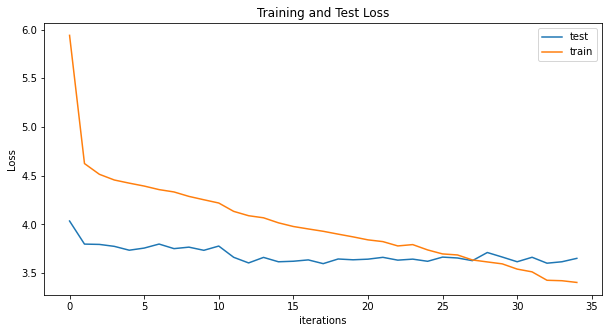

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Training and Test Loss")
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('cmu-qa-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.596 | Test PPL:  36.469 |


In [ ]:
id = 2

example = train_data.examples[id]
print('Question: ', ' '.join(example.Question))
print('Answer: ', ' '.join(example.Answer))

Question:  did lincoln win the election of 1860 ?
Answer:  yes


In [ ]:
ques_tensor = Question.process([example.Question]).to(device)
ans_tensor = Answer.process([example.Answer]).to(device)
print(ans_tensor.shape)

model.eval()
with torch.no_grad():
    outputs = model(ques_tensor, ans_tensor, teacher_forcing_ratio=0)

print(outputs.shape)
output_idx = outputs[1:].squeeze(1).argmax(1)
' '.join([Answer.vocab.itos[idx] for idx in output_idx])

torch.Size([3, 1])
torch.Size([3, 1, 1181])


'yes <eos>'